In [1]:
try:
  import os, sys 
  #to be able to interact with Google Drive's operating system
  from google.colab import drive 
  #drive is a module that allows us use Python to interact with google drive
  drive.mount('/content/gdrive') 
  #mounting google drive allows us to work with its contents
  nb_path = '/content/notebooks'
  os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
  sys.path.insert(0, nb_path)  # or append(nb_path)
  #The last three lines are what changes the path of the file.
except:
  print("Drive already mounted and ready to use!")

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

In [4]:
# Storing all required paths for later use

main_cwd = r'/content/gdrive/My Drive/Colab Notebooks/CNN_Medical_Imaging'
dataset_cwd = os.path.join(main_cwd, "Datasets")
healthy_bones_dataset_cwd = os.path.join(dataset_cwd, "Healthy_bones")
fractured_bones_dataset_cwd = os.path.join(dataset_cwd, "Fractured_bones")
beyond_repair_bones_dataset_cwd = os.path.join(dataset_cwd, "Bones_beyond_repair")

In [5]:
# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
import imagesize
import numpy as np
from sklearn.cluster import KMeans

In [6]:
def get_cwd_files(path):

  ignore_files = [".gitkeep", ".gitignore"]
  path_files = os.listdir(path)
  path_files = [file for file in path_files if file not in ignore_files]

  return path_files

In [7]:
def get_image_resolution(image_data_process_directory, classification_classes):

  # Classes for our prediction
  classification_classes_dict = {1:"Healthy_bones", 2:"Fractured_bones", 3:"Bones_beyond_repair"}

  #flag_counter = 0
  img_meta = {}
  for each_class in classification_classes:
    #flag_counter = 0
    class_category_number = classification_classes.index(each_class)
    bone_class_img_path = os.path.join(image_data_process_directory, each_class)
    #print(bone_class_img_path)
    bone_images = get_cwd_files(bone_class_img_path)
    for bone_image in bone_images:
      
      '''
      if flag_counter == 10:
        break
      flag_counter += 1'''
      
      bone_image_path = os.path.join(bone_class_img_path, bone_image)
      #print(bone_image_path)
      try:
        img_meta[str(bone_image)] = imagesize.get(bone_image_path)
      except:
        print("Some error occured in fetching data!")
      
  # Convert it to Dataframe and compute aspect ratio
  img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['Image_Name', 'Image_Size'], axis='columns', inplace=False)
  img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Image_Size"].tolist(), index=img_meta_df.index)
  img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

  
  return  img_meta, img_meta_df


In [12]:
# Get resolutions for the selected class images
classification_classes = ["Healthy_bones", "Fractured_bones", "Bones_beyond_repair"]
image_meta, image_meta_df = get_image_resolution(dataset_cwd, classification_classes)

In [13]:
# Sneak Peak
print(f"The total number of images processed are {len(image_meta_df)}")
image_meta_df.head()

The total number of images processed are 6422


,Image_Name,Image_Size,Width,Height,Aspect Ratio
0,healthy_bone_image_3370.png,"(406, 512)",406,512,0.79
1,healthy_bone_image_3347.png,"(385, 512)",385,512,0.75
2,healthy_bone_image_3324.png,"(389, 512)",389,512,0.76
3,healthy_bone_image_3343.png,"(335, 512)",335,512,0.65
4,healthy_bone_image_3366.png,"(257, 512)",257,512,0.50


Text(0, 0.5, 'Height')

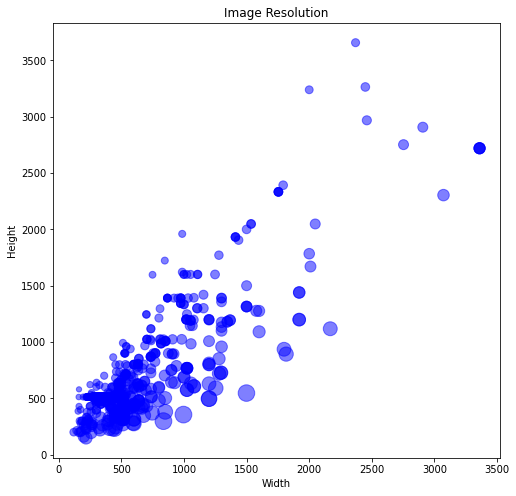

In [14]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(image_meta_df.Width, image_meta_df.Height, color='blue', alpha=0.5, s=image_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=10)
ax.set_ylabel("Height", size=10)

In [27]:
# There are some outliers, let's remove them first
image_meta_df = image_meta_df[image_meta_df["Width"] < 1200]
image_meta_df = image_meta_df[image_meta_df["Height"] < 1000]

# Sneak Peak
print(f"The total number of images present are {len(image_meta_df)}")

The total number of images present are 6291


Text(0, 0.5, 'Height')

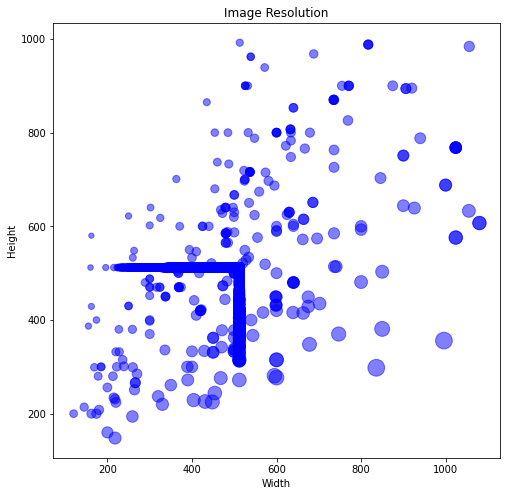

In [28]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(image_meta_df.Width, image_meta_df.Height, color='blue', alpha=0.5, s=image_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=10)
ax.set_ylabel("Height", size=10)

In [29]:
# Storing values for finding cluster means 
#image_data = image_meta_df.drop_duplicates(subset=["Width", "Height"], keep="first")
image_data = image_meta_df.drop(["Image_Name", "Image_Size", "Aspect Ratio"], axis=1)

# Sneak Peak
print(f"The total number of images present are {len(image_data)}")
image_data.head()

The total number of images present are 6291


,Width,Height
0,406,512
1,385,512
2,389,512
3,335,512
4,257,512


In [30]:
# SSE Method for getting optimum value of number of clusters - Method 1
sse = []
clusters_required = 10
for k in range(1, clusters_required):
  km = KMeans(n_clusters = k)
  labels = km.fit_predict(image_data)
  sse.append(km.inertia_)

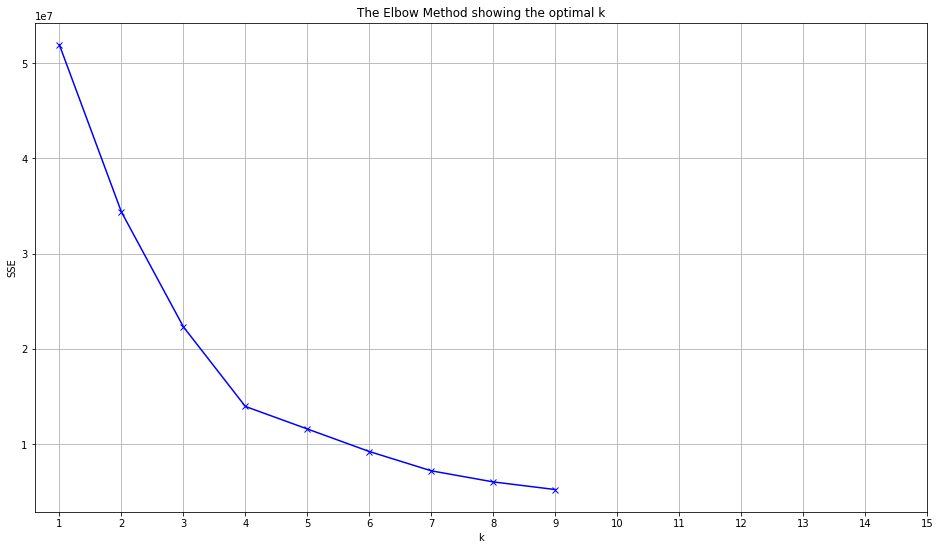

In [31]:
K = range(1, clusters_required)
plt.figure(figsize=(16,9))
# plt.plot(K, sse, color = "b", marker = ".")
plt.plot(K, sse, 'bx-') 
plt.xticks(range(1,16)) 
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid()
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [32]:
# Getting image resolution suggestions
km = KMeans(n_clusters = 3, random_state = 42)
clusters = km.fit_predict(image_data)

# Getting frequency
cluster_count = {}
for co_ord in clusters:
  cluster_count[co_ord] = cluster_count.get(co_ord, 0) + 1

# Sorting dictionary based on key values
cluster_count = sorted(cluster_count.items(), key=lambda x: int(x[1]), reverse=True)

# Cluster centers
centers = km.cluster_centers_
print(f"Cluster group size - {cluster_count[0][1]} and suggested ressolution is {int(centers[1][0]), int(centers[1][1])}")
print(f"Cluster group size - {cluster_count[1][1]} and suggested ressolution is {int(centers[2][0]), int(centers[2][1])}")
print(f"Cluster group size - {cluster_count[2][1]} and suggested ressolution is {int(centers[0][0]), int(centers[0][1])}")

Cluster group size - 5439 and suggested ressolution is (510, 448)
Cluster group size - 755 and suggested ressolution is (713, 767)
Cluster group size - 97 and suggested ressolution is (383, 510)


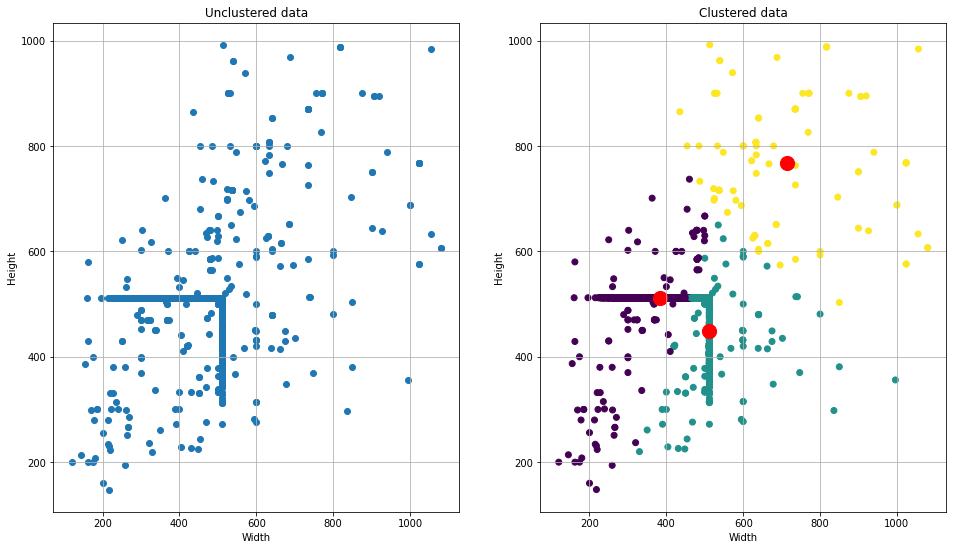

In [33]:
# Plot to visualize
plt.figure(figsize = (16,9))
plt.subplot(1,2,1)
plt.title("Unclustered data")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid()
plt.scatter(image_data["Width"], image_data["Height"])
plt.subplot(1,2,2)
plt.title("Clustered data")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid()
plt.scatter(image_data["Width"], image_data["Height"], c = clusters)
plt.scatter(centers[:,0], centers[:, 1], s = 200, c = "red")  # s - size of the point

### Based on above observation, some prefferable resolution sizes for our CNN model can be (224, 224), (256, 256), (384, 384)